## 1. Instalação e Setup

In [18]:
# YOLO + StrongSORT + OpenCV + Supervision
!pip install ultralytics supervision opencv-python --quiet



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# Importação das bibliotecas necessárias
from ultralytics import YOLO
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt

## 2. Carregando um modelo pré-treinado

In [8]:
# Carregando o modelo YOLOv8n (nano - versão mais leve)
model = YOLO('yolov8x.pt')

# Também podemos carregar diferentes tamanhos de modelo:
# model = YOLO('yolov8s.pt')  # small
# model = YOLO('yolov8m.pt')  # medium
# model = YOLO('yolov8l.pt')  # large
# model = YOLO('yolov8x.pt')  # extra large


In [20]:
# Função para filtrar motos próximas
def filtrar_motos_proximas(boxes, distancia_minima=50):
    
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    centros = np.array([( (x1+x2)/2, (y1+y2)/2 ) for x1, y1, x2, y2 in boxes])
    mantidas = []

    for i, centro in enumerate(centros):
        duplicada = False
        for j in mantidas:
            dist = np.linalg.norm(centro - centros[j])
            if dist < distancia_minima:
                duplicada = True
                break
        if not duplicada:
            mantidas.append(i)

    return boxes[mantidas]


In [22]:

# Define a função detectar_moto_na_imagem, 
# que executa a detecção de motos em uma imagem
localizacoes_motos = {}

def detectar_moto_na_imagem(caminho):
    print(f"\nProcessando imagem: {caminho}")
    resultados = model.predict(
        source=caminho,
        conf=0.3,
        iou=0.7,
        max_det=500,
        classes=[3],  # Só motos
        save=True,
        project='resultados_imagens',
        name='detectados',
        exist_ok=True
    )
    mostrar_deteccao(caminho, resultados)
    explorar_resultados(resultados)

    # Salva as coordenadas das motos detectadas com filtro
    if resultados and hasattr(resultados[0], "boxes") and len(resultados[0].boxes) > 0:
        boxes_raw = resultados[0].boxes.xyxy.cpu().numpy()
        boxes_filtradas = filtrar_motos_proximas(boxes_raw, distancia_minima=60)

        for box in boxes_filtradas:
            novo_id = len(localizacoes_motos)
            localizacoes_motos[novo_id] = box
            print(f"  Moto detectada! ID: {novo_id} | Coordenadas: {box}")
    else:
        print("  Nenhuma moto detectada nesta imagem.")


In [24]:
# Define a função mostrar_deteccao, que exibe a 
# imagem com as detecções feitas pelo YOLO
def mostrar_deteccao(imagem, resultados):
    # Mostra a imagem com as detecções do YOLOv8
    if isinstance(imagem, str):
        imagem = cv2.imread(imagem)
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(resultados[0].plot())
    plt.axis('off')
    plt.show()

    # Printando detalhes das detecções
    caixas = resultados[0].boxes
    print(f"\nForam detectados {len(caixas)} objetos na imagem.")

    for i, box in enumerate(caixas):
        classe = int(box.cls[0])
        nome = model.names[classe]
        confianca = float(box.conf[0])
        print(f"Detecção {i+1}: {nome} (confiança: {confianca:.2f})")

## 4. Função para explorar os resultados

In [25]:
# imprime informações detalhadas sobre todas as detecções
def explorar_resultados(resultados):
    if not resultados or not hasattr(resultados[0], "boxes") or len(resultados[0].boxes) == 0:
        print("Nenhum resultado encontrado para explorar.")
        return

    resultado = resultados[0]

    print("\n=== Informações do resultado ===")
    print(f"Tipo do objeto resultado: {type(resultado)}")
    print(f"Quantidade de boxes (detecções): {len(resultado.boxes)}")

    print("\n--- Detalhes de cada box ---")
    for i, box in enumerate(resultado.boxes):
        print(f"Box {i}:")
        print(f"  Coordenadas: {box.xyxy.cpu().numpy()}")
        print(f"  Classe: {box.cls.cpu().numpy()}")
        print(f"  Confiança: {box.conf.cpu().numpy()}")

    print("\nBounding boxes (todas):")
    print(resultado.boxes.xyxy.cpu().numpy())

    print("\nClasses detectadas (índices):")
    print(resultado.boxes.cls.cpu().numpy())

    print("\nNomes das classes detectadas:")
    for c in resultado.boxes.cls:
        print(model.names[int(c)])

    print("\nScores de confiança:")
    print(resultado.boxes.conf.cpu().numpy())
    print("=== Fim dos resultados ===\n")

## 5. Detecção em imagem com retorno e visualização

In [26]:
# Crie o dicionário só uma vez, antes de rodar as detecções
localizacoes_motos = {}

def detectar_moto_na_imagem(caminho):
    print(f"\nProcessando imagem: {caminho}")
    resultados = model.predict(
        source=caminho,
        conf=0.01,
        iou=0.7,
        max_det=500,
        classes=[3],  # Só motos
        save=True,
        project='resultados_imagens',
        name='detectados',
        exist_ok=True
    )
    mostrar_deteccao(caminho, resultados)
    explorar_resultados(resultados)

    # Salva as coordenadas das motos detectadas
    if resultados and hasattr(resultados[0], "boxes") and len(resultados[0].boxes) > 0:
        for box in resultados[0].boxes.xyxy.cpu().numpy():
            novo_id = len(localizacoes_motos)
            localizacoes_motos[novo_id] = box
            print(f"  Moto detectada! ID: {novo_id} | Coordenadas: {box}")
    else:
        print("  Nenhuma moto detectada nesta imagem.")

## 6. Executar detecção em todos arquivos da pasta


Processando imagem: imangesMotos.jpg

image 1/1 c:\Users\luizf\fiap-mottu-yolo-detection\imangesMotos.jpg: 384x640 352 motorcycles, 4174.9ms
Speed: 62.1ms preprocess, 4174.9ms inference, 78.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to resultados_imagens\detectados


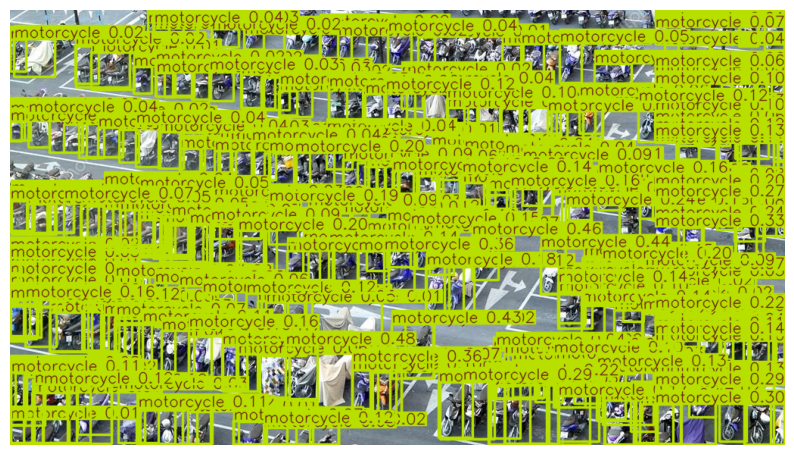


Foram detectados 352 objetos na imagem.
Detecção 1: motorcycle (confiança: 0.48)
Detecção 2: motorcycle (confiança: 0.46)
Detecção 3: motorcycle (confiança: 0.44)
Detecção 4: motorcycle (confiança: 0.43)
Detecção 5: motorcycle (confiança: 0.36)
Detecção 6: motorcycle (confiança: 0.36)
Detecção 7: motorcycle (confiança: 0.33)
Detecção 8: motorcycle (confiança: 0.30)
Detecção 9: motorcycle (confiança: 0.29)
Detecção 10: motorcycle (confiança: 0.29)
Detecção 11: motorcycle (confiança: 0.29)
Detecção 12: motorcycle (confiança: 0.27)
Detecção 13: motorcycle (confiança: 0.25)
Detecção 14: motorcycle (confiança: 0.24)
Detecção 15: motorcycle (confiança: 0.24)
Detecção 16: motorcycle (confiança: 0.22)
Detecção 17: motorcycle (confiança: 0.22)
Detecção 18: motorcycle (confiança: 0.20)
Detecção 19: motorcycle (confiança: 0.20)
Detecção 20: motorcycle (confiança: 0.20)
Detecção 21: motorcycle (confiança: 0.20)
Detecção 22: motorcycle (confiança: 0.19)
Detecção 23: motorcycle (confiança: 0.19)
De

In [27]:
#Executa a detecção em todas as imagens da pasta raiz.

import os
from pathlib import Path

# Extensões de imagem aceitas
extensoes_imagem = ['.jpg', '.jpeg', '.png']

# Pasta onde as imagens estão (pasta raiz do projeto)
pasta_raiz = Path('.')

# Pasta onde os resultados serão salvos
pasta_resultados = pasta_raiz / 'resultados_imagens' / 'detectados'
pasta_resultados.mkdir(parents=True, exist_ok=True)  # Cria a pasta se não existir

# Lista apenas arquivos de imagem da pasta raiz
imagens = [f for f in os.listdir(pasta_raiz) if Path(f).suffix.lower() in extensoes_imagem]

# Roda a detecção em cada imagem e salva os resultados
for img in imagens:
    caminho_img = str(pasta_raiz / img)
    detectar_moto_na_imagem(caminho_img)

## 7. registrar localização de motos detectadas em fotos

In [28]:
#Mostra a posição (bounding box) de uma moto detectada pelo ID.
def mostrar_posicao_moto(id_moto):
    print(f"Buscando posição da moto com ID {id_moto}...")
    if id_moto in localizacoes_motos:
        coord = localizacoes_motos[id_moto]
        print(f"Moto ID {id_moto} está na posição (bounding box): {coord}")
    else:
        print(f"Moto ID {id_moto} não encontrada. Tente outro número!")

## 8. exibição em mapa 2D

In [29]:
# Mostra um gráfico 2D com as posições das motos detectadas.
def mapa_2d_motos():
    # Mostra um gráfico com as posições das motos detectadas
    if not localizacoes_motos:
        print("Não tem nenhuma moto pra mostrar no mapa.")
        return

    plt.figure(figsize=(10, 6))
    plt.title("Mapa 2D das Motos Detectadas")
    plt.xlabel("Eixo X (largura da imagem)")
    plt.ylabel("Eixo Y (altura da imagem)")
    plt.grid(True)

    for id_moto, (x1, y1, x2, y2) in localizacoes_motos.items():
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        plt.plot(cx, cy, "ro")
        plt.text(cx + 5, cy, f"ID {id_moto}", fontsize=10, color='blue')

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

IDs das motos detectadas: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216

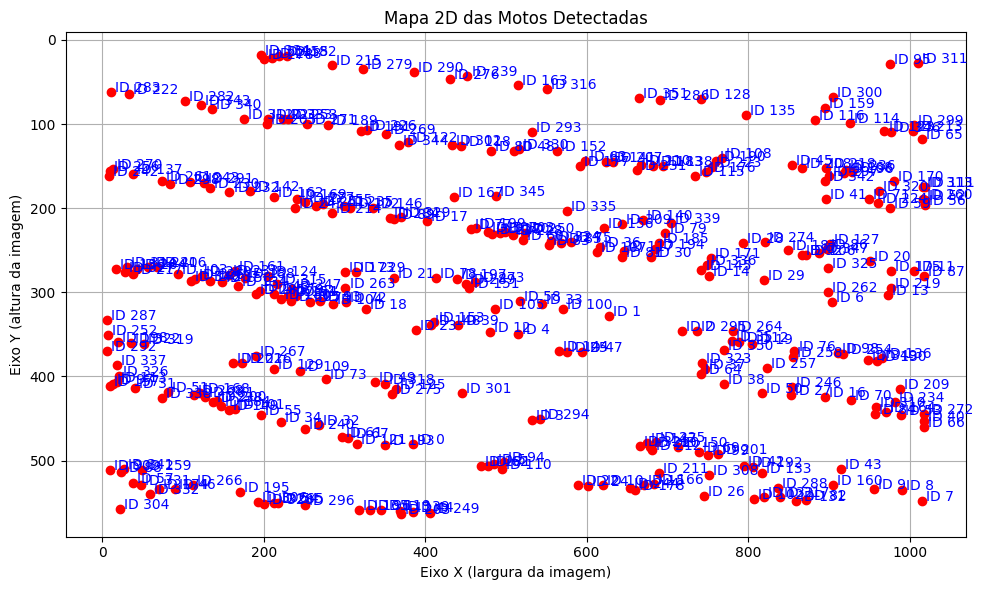

In [30]:
# Exibe todas as motos detectadas no terminal
print("IDs das motos detectadas:", list(localizacoes_motos.keys()))
for id_moto in localizacoes_motos:
    mostrar_posicao_moto(id_moto)

# Exibe o mapa 2D com todas as motos
mapa_2d_motos()

##  9. Lista de classes COCO

In [28]:
# Lista de todas as classes que o modelo reconhece
for idx, class_name in model.names.items():
    print(f"{idx}: {class_name}")


0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow
20: elephant
21: bear
22: zebra
23: giraffe
24: backpack
25: umbrella
26: handbag
27: tie
28: suitcase
29: frisbee
30: skis
31: snowboard
32: sports ball
33: kite
34: baseball bat
35: baseball glove
36: skateboard
37: surfboard
38: tennis racket
39: bottle
40: wine glass
41: cup
42: fork
43: knife
44: spoon
45: bowl
46: banana
47: apple
48: sandwich
49: orange
50: broccoli
51: carrot
52: hot dog
53: pizza
54: donut
55: cake
56: chair
57: couch
58: potted plant
59: bed
60: dining table
61: toilet
62: tv
63: laptop
64: mouse
65: remote
66: keyboard
67: cell phone
68: microwave
69: oven
70: toaster
71: sink
72: refrigerator
73: book
74: clock
75: vase
76: scissors
77: teddy bear
78: hair drier
79: toothbrush
